# Modeling the disparity between experienced and residential nativity segregation

In [1]:
%load_ext autoreload
%autoreload 2
%cd D:\mobi-social-segregation-se

D:\mobi-social-segregation-se


In [2]:
# Load libs
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from interpret.glassbox import ExplainableBoostingRegressor
import seaborn as sns
import shap

C:\Users\yuanlia\AppData\Local\Temp\ipykernel_23124\1699322564.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)
font = {'size': 14}
mpl.rc('font', **font)

In [4]:
df_exp = pd.read_parquet('results/data4model_individual.parquet')
df_exp = df_exp.loc[(df_exp['weekday'] == 1) & (df_exp['holiday'] == 0), :]

## 1. Select variables

In [5]:
cols = ['uid', 'region', 'wt_p',
        'Lowest income group', 'car_ownership', 'radius_of_gyration',
        'cum_jobs_pt', 'cum_jobs_car',
        'ice_birth_resi', 'ice_birth']
df_exp = df_exp[cols]

### 1.1 Add labels of home regions (A, B, and C)
A DeSO in category A is mostly outside major population concentrations or urban areas. DeSO in category B is mostly located in a population concentration or agglomeration, but not in the municipality's central location. Category C includes DeSO, which is mostly located in the municipality's central location. In total, 18 percent of DeSO are found in category A, 10 percent in category B and 72 percent in category C.

Source: [SCB.se](https://www.scb.se/hitta-statistik/regional-statistik-och-kartor/regionala-indelningar/deso---demografiska-statistikomraden/)

In [6]:
df_exp.loc[:, 'deso_2'] = df_exp['region'].apply(lambda x: x[0:2])
df_exp.loc[:, 'region_cat'] = df_exp['region'].apply(lambda x: x[4])

## 2. Grouping segregation patterns

In [7]:
def seg_direction(row):
    if row['ice_birth_resi'] < 0:
        if row['ice_birth'] < 0:
            return 'FF'
        else:
            return 'FD'
    else:
        if row['ice_birth'] < 0:
            return 'DF'
    return 'DD'

def delta_ice(ice_r, ice_e):
    if ice_r < 0:
        return -(ice_e - ice_r)
    return ice_e - ice_r

def seg_abs_direction(x):
    if x >= 0:
        return 'inc'
    return 'dec'

In [8]:
df_exp.loc[:, 'seg_gap'] = df_exp.apply(lambda row: delta_ice(row['ice_birth_resi'], row['ice_birth']), axis=1)
df_exp.loc[:, 'seg_cross'] = df_exp.apply(lambda row: seg_direction(row), axis=1)
df_exp.loc[:, 'seg_change'] = df_exp.apply(lambda row: seg_abs_direction(row['seg_gap']), axis=1)
df_exp.loc[:, 'seg_r'] = df_exp.apply(lambda row: row['seg_cross'][0], axis=1)
df_exp.loc[:, 'region_cat2'] = df_exp['region_cat'].apply(lambda x: 'Rural/Suburban' if x in ('A', 'B') else 'Urban')
df_exp.iloc[0]

uid                    00008608-f79e-414d-bf1c-25632d6bc059
region                                            1284C1040
wt_p                                              84.428571
Lowest income group                                0.088063
car_ownership                                      0.541455
radius_of_gyration                               114.406844
cum_jobs_pt                                             296
cum_jobs_car                                        65662.0
ice_birth_resi                                     0.324146
ice_birth                                          0.041918
deso_2                                                   12
region_cat                                                C
seg_gap                                           -0.282228
seg_cross                                                DD
seg_change                                              dec
seg_r                                                     D
region_cat2                             

In [9]:
df_exp.loc[:, 'ice_birth_resi_cat'] = pd.cut(df_exp.ice_birth_resi,
                                             bins=[-1,-0.6,-0.2,0.2,0.6,1],
                                             labels=['F2','F1','N','D1','D2'])

In [10]:
df_exp.groupby('ice_birth_resi_cat')['wt_p'].sum()

ice_birth_resi_cat
F2    1.439210e+05
F1    1.616072e+06
N     4.007675e+06
D1    3.883616e+06
D2    3.435659e+05
Name: wt_p, dtype: float64

### 2.1 Control for income, rg, and car ownership

In [11]:
len(df_exp.loc[df_exp['radius_of_gyration'] > 0, :]) / len(df_exp)

1.0

In [33]:
df_exp.loc[:, 'rg_log'] = np.log10(df_exp['radius_of_gyration'])

In [34]:
def eval_k_means(estimator, data, weights):
    estimator.fit(data, sample_weight=weights)
    sc = metrics.silhouette_score(data, estimator.labels_, sample_size=10000, random_state=0)
    return sc, estimator.labels_

In [35]:
# df_exp = df_exp.loc[df_exp.ice_birth_resi_cat != 'N', :]

In [36]:
cont_grp = df_exp.loc[:, ['Lowest income group', 'car_ownership', 'rg_log']].values
sample_weight = df_exp['wt_p'].values
scaler = StandardScaler().fit(cont_grp, sample_weight=sample_weight)
cont_grp = scaler.transform(cont_grp)
perf_clusters = []
for n_clusters in tqdm(range(2,7)):
    sc, labels = eval_k_means(KMeans(n_clusters=n_clusters, random_state=0, n_init=10),
                              weights=sample_weight, data=cont_grp)
    perf_clusters.append((n_clusters, sc))
df_cls = pd.DataFrame(perf_clusters, columns=['Number of clusters', 'Silhouette score'])

  0%|          | 0/5 [00:00<?, ?it/s]

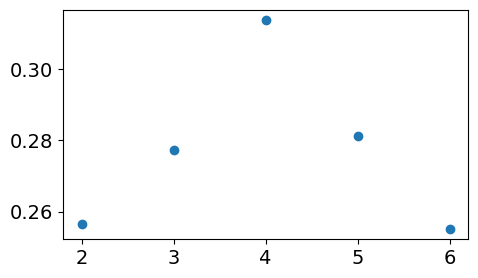

In [37]:
fig = plt.figure(figsize=(5, 3))
plt.scatter(df_cls['Number of clusters'], df_cls['Silhouette score'])
plt.tight_layout()
plt.show()

Choose four clusters

In [38]:
sc, labels = eval_k_means(KMeans(n_clusters=4, random_state=0, n_init=10), weights=sample_weight, data=cont_grp)
print(sc)

0.31367538053100213


In [39]:
df_exp.loc[:, 'ctrl_grp'] = labels
df_exp.groupby('ctrl_grp')['wt_p'].sum()

ctrl_grp
0    1.837906e+06
1    3.874725e+06
2    1.889110e+06
3    2.393108e+06
Name: wt_p, dtype: float64

In [40]:
df_exp.groupby('ctrl_grp')[['Lowest income group', 'car_ownership', 'radius_of_gyration']].median()

,Lowest income group,car_ownership,radius_of_gyration
ctrl_grp,,,
0,0.187500,0.825095,40.880104
1,0.189189,0.410942,95.747098
2,0.500000,0.425247,51.044288
3,0.200000,0.389258,3.451415


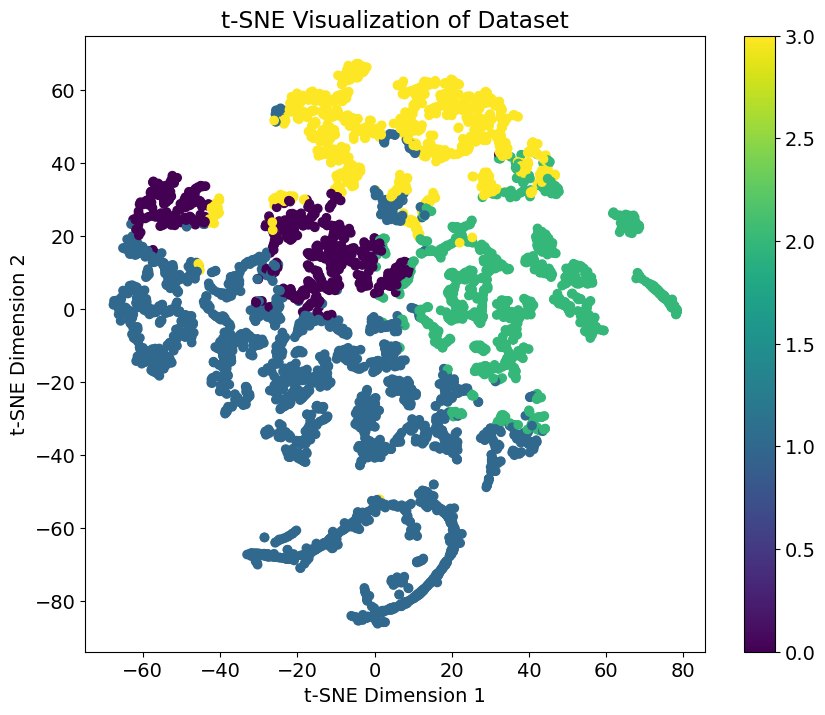

In [41]:
# Step 1: Instantiate the t-SNE model
tsne_model = TSNE(n_components=2, random_state=42)

# Step 2: Fit and transform your data using t-SNE
embedded_data = tsne_model.fit_transform(cont_grp[:5000])

# Step 3: Create a scatter plot to visualize the embedded data
plt.figure(figsize=(10, 8))
plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=labels[:5000], cmap='viridis', marker='o')
plt.colorbar()
plt.title('t-SNE Visualization of Dataset')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [42]:
def ctrl_grp_stats_com(data, var=None):
    stat_dict = {'share': data.wt_p.sum() / df_exp.wt_p.sum() * 100}
    wdf = DescrStatsW(data[var], weights=data['wt_p'], ddof=1)
    sts = wdf.quantile([0.25,0.50,0.75])
    q25 = sts.values[0]
    q50 = sts.values[1]
    q75 = sts.values[2]
    stat_dict['mean'] = wdf.mean
    stat_dict['q25'] = q25
    stat_dict['q50'] = q50
    stat_dict['q75'] = q75
    stat_dict['var'] = var
    return pd.Series(stat_dict)

def ctrl_grp_stats_calculation(df=None, focus_thr=False):
    if focus_thr:
        df_exp = df.loc[df['deso_2'].isin(['01', '12', '14']), :]
    else:
        df_exp = df.copy()
    list_df_ctrl = []
    for var in ['Lowest income group', 'car_ownership', 'radius_of_gyration']:
        list_df_ctrl.append(df_exp.groupby(['ctrl_grp']).
                           apply(lambda x: ctrl_grp_stats_com(x, var)).
                           reset_index())
    df_ctrl = pd.concat(list_df_ctrl)
    if focus_thr:
        df_ctrl.loc[:, 'focus'] = 'yes'
    else:
        df_ctrl.loc[:, 'focus'] = 'no'
    return df_ctrl

In [20]:
df_ctrl = ctrl_grp_stats_calculation(df=df_exp, focus_thr=False)
df_ctrl

,ctrl_grp,share,mean,q25,q50,q75,var,focus
0,0,21.650589,0.181095,0.000000,0.180000,0.291667,Lowest income group,no
1,1,26.178953,0.488976,0.379310,0.454545,0.554545,Lowest income group,no
2,2,52.170458,0.153105,0.083333,0.154930,0.227092,Lowest income group,no
0,0,21.650589,0.841484,0.711340,0.819623,0.931063,car_ownership,no
1,1,26.178953,0.435082,0.296296,0.432897,0.546967,car_ownership,no
2,2,52.170458,0.427178,0.328829,0.445431,0.529064,car_ownership,no
0,0,21.650589,67.465306,11.225761,37.152192,90.733632,radius_of_gyration,no
1,1,26.178953,53.804510,5.362187,23.525400,73.170491,radius_of_gyration,no
2,2,52.170458,81.046622,7.799829,38.927124,105.450138,radius_of_gyration,no


Group 0: "ProsperDrive"

Description: Higher income, higher car ownership, longer mobility range.
Rationale: This name combines "Prosper" to reflect their higher income status and "Drive" to highlight their higher car ownership and extended mobility range.

Group 1: "ThriftyMove"

Description: Lower income, lower car ownership, shorter mobility range.
Rationale: The name "Thrifty" emphasizes their cost-conscious approach due to lower income, and "Move" represents their reliance on more economical mobility options.

Group 2: "EliteWander"

Description: Higher income, lower car ownership, longer mobility range.
Rationale: "Elite" suggests their higher socio-economic status, and "Wander" captures their ability to roam extensively despite not owning cars.

In [21]:
df_exp.to_parquet("results/transport_association/seg_disparity_patterns.parquet")

In [22]:
df_ctrl.to_parquet("results/transport_association/three_travelers.parquet")

Traveler composition by DeSO zone

In [23]:
def grp2vector(data):
    tot = data['wt_p'].sum()
    s = data.groupby('ctrl_grp')['wt_p'].sum() / tot
    return pd.Series(s.to_dict(), index=[0, 1, 2])
df_exp_deso = df_exp.groupby(['region']).apply(lambda x: grp2vector(x)).reset_index().fillna(0)
df_exp_deso.columns= ['deso', 'ProsperDrive', 'ThriftyMove', 'EliteWander']

In [24]:
def vec2rgb2hex(row):
    def clamp(x):
        return max(0, min(round(x*255), 255))
    return "#{0:02x}{1:02x}{2:02x}".format(clamp(row['ThriftyMove']),
                                           clamp(row['EliteWander']),
                                           clamp(row['ProsperDrive']))
df_exp_deso.loc[:, 'color'] = df_exp_deso.apply(lambda row: vec2rgb2hex(row), axis=1)
df_exp_deso.head()

,deso,ProsperDrive,ThriftyMove,EliteWander,color
0,0114A0010,1.0,0.000000,0.000000,#0000ff
1,0114C1010,0.0,0.000000,1.000000,#00ff00
2,0114C1020,0.0,0.000000,1.000000,#00ff00
3,0114C1030,0.0,0.000000,1.000000,#00ff00
4,0114C1040,0.0,0.277778,0.722222,#47b800


In [25]:
df_exp_deso.to_parquet("results/transport_association/three_travelers_deso.parquet")

Traveler composition by living area

In [26]:
values_map = {1: 'ThriftyMove', 0: 'ProsperDrive', 2: 'EliteWander'}
df_exp_rc2 = df_exp.groupby(['region_cat2', 'ctrl_grp'])['wt_p'].sum() / df_exp.wt_p.sum() * 100
df_exp_rc2 = df_exp_rc2.reset_index()
df_exp_rc2.loc[:, 'ctrl_grp'] = df_exp_rc2.loc[:, 'ctrl_grp'].map(values_map)
df_exp_rc2 = df_exp_rc2.rename(columns={'wt_p': 'Share'})
df_exp_rc2

,region_cat2,ctrl_grp,Share
0,Rural/Suburban,ProsperDrive,16.502709
1,Rural/Suburban,ThriftyMove,2.827831
2,Rural/Suburban,EliteWander,3.653774
3,Urban,ProsperDrive,5.147880
4,Urban,ThriftyMove,23.351122
5,Urban,EliteWander,48.516684


In [27]:
df_exp_rc2.to_parquet("results/transport_association/three_travelers_distr.parquet")

### 2.2 Statistics of these groups

In [28]:
df_exp_sstats = df_exp.groupby(['seg_r', 'seg_change', 'ctrl_grp'])['wt_p'].sum() / df_exp.wt_p.sum() * 100
df_exp_sstats = df_exp_sstats.reset_index()
df_exp_sstats.loc[:, 'ctrl_grp'] = df_exp_sstats.loc[:, 'ctrl_grp'].map(values_map)
df_exp_sstats = pd.pivot_table(df_exp_sstats, values='wt_p', index=['ctrl_grp'],
                       columns=['seg_r', 'seg_change'])
df_exp_sstats = df_exp_sstats.reset_index()

In [29]:
df_exp_sstats.loc[:, 'sum'] = df_exp_sstats.apply(lambda row: row[df_exp_sstats.columns[1]] + row[df_exp_sstats.columns[2]] + row[df_exp_sstats.columns[3]] + row[df_exp_sstats.columns[4]], axis=1)
for var in df_exp_sstats.columns[1:5]:
    df_exp_sstats.loc[:, var] /= df_exp_sstats.loc[:, 'sum']
    df_exp_sstats.loc[:, var] *= 100
df_exp_sstats

seg_r           ctrl_grp          D                    F                   sum
seg_change                      dec       inc        dec        inc           
0            EliteWander  67.332483  1.909524   7.832293  22.925701  52.170458
1           ProsperDrive  95.619958  1.356407   0.770686   2.252949  21.650589
2            ThriftyMove  31.536044  1.324650  22.986330  44.152976  26.178953

In [106]:
df_exp_sstats.to_clipboard(index=False)

In [30]:
df_exp.groupby(['region_cat2'])['wt_p'].sum() / df_exp.wt_p.sum() * 100

region_cat2
Rural/Suburban    22.984315
Urban             77.015685
Name: wt_p, dtype: float64

In [31]:
df_exp.groupby(['region_cat2', 'ctrl_grp'])['wt_p'].sum() / df_exp.wt_p.sum() * 100

region_cat2     ctrl_grp
Rural/Suburban  0           16.502709
                1            2.827831
                2            3.653774
Urban           0            5.147880
                1           23.351122
                2           48.516684
Name: wt_p, dtype: float64

In [32]:
df_exp.groupby(['seg_r'])['wt_p'].sum() / df_exp.wt_p.sum() * 100

seg_r
D    65.722412
F    34.277588
Name: wt_p, dtype: float64

In [33]:
df_exp.groupby(['seg_r', 'ctrl_grp'])['wt_p'].sum() / df_exp.wt_p.sum() * 100

seg_r  ctrl_grp
D      0           20.995954
       1            8.602586
       2           36.123872
F      0            0.654635
       1           17.576367
       2           16.046586
Name: wt_p, dtype: float64

## 3. Quantify segregation disparity

In [12]:
df_exp_d = df_exp.loc[df_exp['ice_birth_resi_cat'].isin(['D1', 'D2']), :]
df_exp_f = df_exp.loc[df_exp['ice_birth_resi_cat'].isin(['F1', 'F2']), :]
reg_d = LinearRegression().fit(X=df_exp_d['ice_birth_resi'].to_numpy().reshape(len(df_exp_d), 1), 
                               y=df_exp_d['ice_birth'].to_numpy(), sample_weight=df_exp_d['wt_p'].to_numpy())
reg_f = LinearRegression().fit(X=df_exp_f['ice_birth_resi'].to_numpy().reshape(len(df_exp_f), 1), 
                               y=df_exp_f['ice_birth'].to_numpy(), sample_weight=df_exp_f['wt_p'].to_numpy())

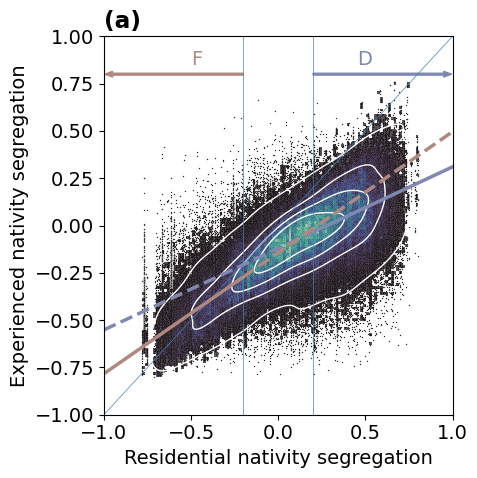

In [21]:
sp = df_exp.sample(10000, random_state=0)
f_color, d_color = '#af887f', '#7f88af'
f, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=df_exp, x='ice_birth_resi', y='ice_birth', s=1, color=".15")
sns.histplot(data=df_exp, x='ice_birth_resi', y='ice_birth', weights=df_exp.wt_p,
                 cmap="mako", bins=100, pthresh=.01, alpha=0.7)
sns.kdeplot(data=sp, x='ice_birth_resi', y='ice_birth', weights=sp.wt_p,
            levels=5, color="w", linewidths=1)
ax.plot([-1, 1], [-1, 1], '-', linewidth = 0.5, color='steelblue')
ax.plot([0.2, 0.2], [-1, 1], '-', linewidth = 0.5, color='steelblue')
ax.plot([-0.2, -0.2], [-1, 1], '-', linewidth = 0.5, color='steelblue')
ax.set_xlabel('Residential nativity segregation')
ax.set_ylabel('Experienced nativity segregation')
ax.text(-0.5, 0.85, "F", color=f_color)
ax.arrow(-0.2, 0.8, -0.75, 0, width=0.01, color=f_color)
ax.text(0.45, 0.85, "D", color=d_color)
ax.arrow(0.2, 0.8, 0.75, 0, width=0.01, color=d_color)
# plot the regression line on the extended canvas
new_x_d = np.arange(0.2, 1, 0.8/250.)
new_x_f = np.arange(-1,-0.2, 0.8/250.)
new_x_dc = np.arange(-1, 0.2, 0.8/250.)
new_x_fc = np.arange(-0.2, 1, 0.8/250.)
ax.plot(new_x_d, reg_d.intercept_ + reg_d.coef_[0] *  new_x_d, color=d_color, linestyle='-', lw = 2.5)
ax.plot(new_x_f, reg_f.intercept_ + reg_f.coef_[0] *  new_x_f, color=f_color, linestyle='-', lw = 2.5)
ax.plot(new_x_dc, reg_d.intercept_ + reg_d.coef_[0] *  new_x_dc, color=d_color, linestyle='--', lw = 2.5)
ax.plot(new_x_fc, reg_f.intercept_ + reg_f.coef_[0] *  new_x_fc, color=f_color, linestyle='--', lw = 2.5)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_title('(a)', loc='left', fontweight='bold')
plt.tight_layout()
f.savefig("figures/seg_disp_res.png", dpi=300)

Prepare data for mapping (Central Gothenburg)

In [15]:
def wt_mean(data):
    ice_r = np.average(data['ice_birth_resi'], weights=data['wt_p'])
    ice_e = np.average(data['ice_birth'], weights=data['wt_p'])
    return pd.Series({'ice_r': ice_r, 'ice_e': ice_e})
df_map = df_exp.loc[df_exp.deso_2 == '14', :].\
    groupby('region')[['ice_birth_resi', 'ice_birth', 'wt_p']].\
    apply(wt_mean).reset_index()
df_map.head()

,region,ice_r,ice_e
0,1401A0010,0.305002,-0.009293
1,1401A0020,0.345721,-0.134573
2,1401B2010,0.208143,-0.103023
3,1401B2020,0.403796,-0.003776
4,1401B3010,0.314043,0.048523


In [17]:
df_map.rename(columns={'region': 'deso'}).to_parquet('results/seg_disparity_map.parquet', index=False)

### 3.0 Distributions

In [22]:
pop = df_exp.wt_p.sum()
df_exp.groupby(['ice_birth_resi_cat', 'seg_change'])['wt_p'].sum()/pop*100

ice_birth_resi_cat  seg_change
F2                  dec            1.034473
                    inc            0.405478
F1                  dec            6.703153
                    inc            9.465891
N                   dec           24.738234
                    inc           15.359172
D1                  dec           38.451613
                    inc            0.404556
D2                  dec            3.428864
                    inc            0.008566
Name: wt_p, dtype: float64

In [23]:
df_exp.groupby('ice_birth_resi_cat')['wt_p'].sum()/pop*100

ice_birth_resi_cat
F2     1.439951
F1    16.169043
N     40.097406
D1    38.856169
D2     3.437430
Name: wt_p, dtype: float64

### 3.1 Calculate boxplot stats

In [40]:
def seg_grp_stats_com(data, var=None):
    stat_dict = {'share': data.wt_p.sum() / df_exp.wt_p.sum() * 100}
    wdf = DescrStatsW(data[var], weights=data['wt_p'], ddof=1)
    sts = wdf.quantile([0.25,0.50,0.75])
    q25 = sts.values[0]
    q50 = sts.values[1]
    q75 = sts.values[2]
    stat_dict['mean'] = wdf.mean
    stat_dict['q25'] = q25
    stat_dict['q50'] = q50
    stat_dict['q75'] = q75
    stat_dict['var'] = var
    return pd.Series(stat_dict)

def stats_calculation(df=None, focus_thr=False):
    if focus_thr:
        df_exp = df.loc[df['deso_2'].isin(['01', '12', '14']), :]
    else:
        df_exp = df.copy()
    list_df_seg = []
    for var in ['Lowest income group', 'car_ownership', 'cum_jobs_pt', 'cum_jobs_car']:
        list_df_seg.append(df_exp.groupby(['seg_r', 'seg_change', 'region_cat2']).
                           apply(lambda x: seg_grp_stats_com(x, var)).
                           reset_index())
    df_seg = pd.concat(list_df_seg)
    df_seg.loc[:, 'seg_change'] = df_seg['seg_change'].map({'inc': 'Increase',
                                                            'dec': 'Decrease'})
    if focus_thr:
        df_seg.loc[:, 'focus'] = 'yes'
    else:
        df_seg.loc[:, 'focus'] = 'no'
    df_seg.loc[:, 'ctrl_grp'] = 'None'
    return df_seg

def stats_calculation_by_grp(df=None, focus_thr=False):
    if focus_thr:
        df_exp = df.loc[df['deso_2'].isin(['01', '12', '14']), :]
    else:
        df_exp = df.copy()
    list_df_seg = []
    for var in ['cum_jobs_pt', 'cum_jobs_car']:
        list_df_seg.append(df_exp.groupby(['seg_r', 'seg_change', 'region_cat2', 'ctrl_grp']).
                           apply(lambda x: seg_grp_stats_com(x, var)).
                           reset_index())
    df_seg = pd.concat(list_df_seg)
    df_seg.loc[:, 'seg_change'] = df_seg['seg_change'].map({'inc': 'Increase',
                                                            'dec': 'Decrease'})
    if focus_thr:
        df_seg.loc[:, 'focus'] = 'yes'
    else:
        df_seg.loc[:, 'focus'] = 'no'
    df_seg.loc[:, 'ctrl_grp'] = df_seg.loc[:, 'ctrl_grp'].astype(str)
    return df_seg

In [44]:
df_exp2analysis = df_exp.loc[df_exp.ice_birth_resi_cat != 'N', :]
print("Share of segregated individuals:", df_exp2analysis.wt_p.sum()/df_exp.wt_p.sum()*100)

Share of segregated individuals: 59.90259351772571


In [56]:
df_seg = pd.concat([stats_calculation(df=df_exp, focus_thr=False),
                    stats_calculation(df=df_exp, focus_thr=True),
                    stats_calculation_by_grp(df=df_exp, focus_thr=False)])

In [57]:
df_seg.to_parquet('results/transport_association/seg_disarity_patterns_stats.parquet')
df_seg

,seg_r,seg_change,region_cat2,share,mean,q25,q50,q75,var,focus,ctrl_grp
0,D,Decrease,Rural/Suburban,21.307697,0.213901,0.000000,0.187500,0.333333,Lowest income group,no,None
1,D,Decrease,Urban,42.778058,0.186398,0.085714,0.162617,0.260274,Lowest income group,no,None
2,D,Increase,Rural/Suburban,0.311240,0.270103,0.121212,0.230769,0.380952,Lowest income group,no,None
3,D,Increase,Urban,1.325417,0.224882,0.107438,0.216039,0.308311,Lowest income group,no,None
4,F,Decrease,Rural/Suburban,0.311160,0.321685,0.170213,0.338983,0.449324,Lowest income group,no,None
...,...,...,...,...,...,...,...,...,...,...,...
19,F,Increase,Rural/Suburban,0.493365,22258.840723,5687.000000,13444.000000,30855.000000,cum_jobs_car,no,1
20,F,Increase,Rural/Suburban,0.357170,67771.088895,13999.000000,28163.000000,73300.000000,cum_jobs_car,no,2
21,F,Increase,Urban,0.284094,49502.835707,2642.000000,8357.000000,82246.000000,cum_jobs_car,no,0
22,F,Increase,Urban,11.065422,201196.359154,30577.000000,72706.000000,290168.000000,cum_jobs_car,no,1


### 3.2 Vislualization
This part is done in `30-1-seg-disp-patterns-cat.R`.

## 4. Weighted Mann–Whitney U test

In [45]:
import os
os.environ['R_HOME'] = "C:\Program Files\R\R-4.0.2"
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri as rpyn
from rpy2.robjects.packages import importr
from rpy2.robjects import conversion, default_converter
with conversion.localconverter(default_converter):
    r_weights = importr('survey')

In [46]:
def wmu_test(data=None, region=None, grps=None, var=None, weight=None):
    data1 = data.loc[(data.region_cat2 == region) &
                       (data.seg_r == grps[0]) &
                       (data.seg_change == 'dec'), [var, weight]]
    data2 = data.loc[(data.region_cat2 == region) &
                       (data.seg_r == grps[0]) &
                       (data.seg_change == 'inc'), [var, weight]]
    weights1 = data1[weight].values
    weights2 = data2[weight].values
    weights = np.concatenate([weights1, weights2])
    group1 = data1[var].values
    group2 = data2[var].values
    with conversion.localconverter(default_converter):
        ro.r.assign('group1', rpyn.numpy2rpy(group1))
        ro.r.assign('group2', rpyn.numpy2rpy(group2))
        ro.r.assign('weights', rpyn.numpy2rpy(weights))
        ro.r.assign('weights1', rpyn.numpy2rpy(weights1))
        ro.r.assign('weights2', rpyn.numpy2rpy(weights2))
        ro.r('''data <- data.frame(group = c(group1, group2),
                        group_indicator = rep(c(1, 2), c(length(group1), length(group2))))''')
        ro.r('''design <- svydesign(ids = ~0, data = data, weights = ~weights)''')
        ro.r('''result <- svyranktest(formula = group ~ group_indicator, design=design, test = "wilcoxon")''')
        ro.r('''est <- unname(result$estimate)''')
        ro.r('''pvalue <- unname(result$p.value)''')
        est = ro.globalenv['est'][0]
        pvalue = ro.globalenv['pvalue'][0]
    return est, pvalue

In [47]:
def cohen_d(data=None, region=None, grps=None, var=None, weight=None):
    data1 = data.loc[(data.region_cat2 == region) &
                       (data.seg_r == grps[0]) &
                       (data.seg_change == 'dec'), [var, weight]]
    data2 = data.loc[(data.region_cat2 == region) &
                       (data.seg_r == grps[0]) &
                       (data.seg_change == 'inc'), [var, weight]]
    wdf1 = DescrStatsW(data1[var], weights=data1['wt_p'], ddof=1)
    wdf2 = DescrStatsW(data2[var], weights=data2['wt_p'], ddof=1)
    diff = wdf1.mean - wdf2.mean
    pooledstdev = np.sqrt((wdf1.std**2 * (data1['wt_p'].sum() - 1) + wdf2.std**2 * (data2['wt_p'].sum() - 1))/
                          (data1['wt_p'].sum() + data2['wt_p'].sum() - 2) )
    cohend = diff / pooledstdev
    return cohend

def eff_size(x):
    if abs(x) < 0.2:
        return 'Very small'
    elif 0.2 <= abs(x) < 0.5:
        return 'Small'
    elif 0.5 <= abs(x) < 0.8:
        return 'Medium'
    return 'Large'

### 4.1 By variable

In [58]:
weight = 'wt_p'
res_list = []
for var in ['Lowest income group', 'car_ownership', 'cum_jobs_pt', 'cum_jobs_car']:
    for rg in ['Rural/Suburban', 'Urban']:
        for grp in ['D', 'F']:
            est, pvalue = wmu_test(data=df_exp, region=rg, grps=grp, var=var, weight=weight)
            grp_type = grp[0]
            if pvalue > 0.001:
                sig = '-'
            else:
                sig = '*'
            res_list.append((var, rg, grp_type, pvalue, sig, est))
df_res = pd.DataFrame(res_list, columns=['var', 'region_cat', 'seg_r', 'p', 'sig', 'difference in mean rank score'])
df_res

,var,region_cat,seg_r,p,sig,difference in mean rank score
0,Lowest income group,Rural/Suburban,D,7.209797e-11,*,0.079985
1,Lowest income group,Rural/Suburban,F,2.322064e-01,-,0.015168
2,Lowest income group,Urban,D,5.477563e-28,*,0.078887
3,Lowest income group,Urban,F,2.126838e-241,*,-0.081050
4,car_ownership,Rural/Suburban,D,1.456807e-48,*,-0.184638
5,car_ownership,Rural/Suburban,F,1.075723e-02,-,0.031847
6,car_ownership,Urban,D,7.135697e-07,*,0.030143
7,car_ownership,Urban,F,0.000000e+00,*,0.115891
8,cum_jobs_pt,Rural/Suburban,D,1.624364e-56,*,0.187184
9,cum_jobs_pt,Rural/Suburban,F,9.069236e-01,-,0.001604


In [52]:
df_res.to_clipboard(index=False)

In [59]:
df_res.to_parquet('results/transport_association/stats_test.parquet')

### 4.2 By groups of income, car ownership, and mobility range

In [60]:
weight = 'wt_p'
res_list = []
for var in ['cum_jobs_pt', 'cum_jobs_car']:
    for rg in ['Rural/Suburban', 'Urban']:
        for ctrl in [0, 1, 2]:
            for grp in ['D', 'F']:
                est, pvalue = wmu_test(data=df_exp.loc[df_exp['ctrl_grp']==ctrl, :],
                                       region=rg, grps=grp, var=var, weight=weight)
                cohend = cohen_d(data=df_exp.loc[df_exp['ctrl_grp']==ctrl, :],
                                 region=rg, grps=grp, var=var, weight=weight)
                grp_type = grp[0]
                if pvalue > 0.001:
                    sig = '-'
                else:
                    sig = '*'
                res_list.append((var, rg, str(ctrl), grp_type, pvalue, sig, est, cohend))
df_res = pd.DataFrame(res_list, columns=['var', 'region_cat2', 'ctrl_grp', 'seg_r', 'p', 'sig', 'difference in mean rank score', 'cohen_d'])
df_res.loc[:, 'effsize'] = df_res.loc[:, 'cohen_d'].apply(lambda x: eff_size(x))
df_res

,var,region_cat2,ctrl_grp,seg_r,p,sig,difference in mean rank score,cohen_d,effsize
0,cum_jobs_pt,Rural/Suburban,0,D,1.981824e-19,*,0.173095,-0.265161,Small
1,cum_jobs_pt,Rural/Suburban,0,F,6.447252e-01,-,0.011881,-0.023904,Very small
2,cum_jobs_pt,Rural/Suburban,1,D,1.530691e-08,*,0.128034,-0.143766,Very small
3,cum_jobs_pt,Rural/Suburban,1,F,1.889317e-02,-,-0.049108,0.184485,Very small
4,cum_jobs_pt,Rural/Suburban,2,D,1.218833e-01,-,-0.030796,0.115397,Very small
5,cum_jobs_pt,Rural/Suburban,2,F,2.063029e-01,-,0.030306,-0.017404,Very small
6,cum_jobs_pt,Urban,0,D,1.654381e-04,*,0.068770,-0.182560,Very small
7,cum_jobs_pt,Urban,0,F,8.021640e-01,-,0.005330,-0.231849,Small
8,cum_jobs_pt,Urban,1,D,3.746489e-02,-,-0.028018,0.073695,Very small
9,cum_jobs_pt,Urban,1,F,9.331357e-01,-,-0.000261,0.025123,Very small


In [61]:
df_res.to_parquet('results/transport_association/stats_test_ctrl_grp.parquet')

## 5. EBM model predicting segregation gap

In [37]:
def ebm_group(data, title='Test', weight_field=None, shap_size=500):
#    data = pd.get_dummies(data, columns=['region_cat'], prefix='region_cat_', prefix_sep='')
    data = data.rename(columns={'car_ownership': 'Car ownership (/capita)',
                                'cum_jobs': 'Car accessibility to jobs',
                                'cum_stops': 'Access to transit stops'})
    predictors = ['Lowest income group', 'Car ownership (/capita)',
                  'Car accessibility to jobs', 'Access to transit stops']

    target_column = 'seg_gap'
    X = data[predictors]
    y = data[target_column]
    sample_weight = data[weight_field]

    X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(X, y, sample_weight, test_size=0.00001, random_state=40)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    seed = 1
    ebm = ExplainableBoostingRegressor(interactions=3, random_state=seed, feature_names=predictors, outer_bags=2)
    ebm.fit(X_train, y_train, sample_weight=weight_train)
    # explain the GAM model with SHAP
    background = shap.maskers.Independent(X_train, max_samples=1000)
    explainer_ebm = shap.Explainer(ebm.predict, background)
    shap_values_ebm = explainer_ebm(X_train[:shap_size])
    shap_values_ebm.feature_names = predictors
    # Customize the order of features
    order = predictors
    col2num = {col: i for i, col in enumerate(X.columns)}
    order = list(map(col2num.get, order))
    # Get the current figure and axes objects.
    fig = plt.figure(figsize=(5, 3))
    shap.plots.beeswarm(shap_values_ebm, order=order, show=False, alpha=0.5, log_scale=False)
    # Make the modifications that you want.  I wanted
    # to resize the x-axis, but you can do anything that you'd like.
    plt.title(title)
    # plt.xlim(-0.3, 0.3)
    plt.xlabel('Impact on nativity segregation change')
    plt.tight_layout()
    plt.show()
    fig.savefig(f'figures/ebm/ice_gap_shap_{title.replace("/", "_")}.png', dpi=300)

Exact explainer: 10001it [00:30, 213.54it/s]                          


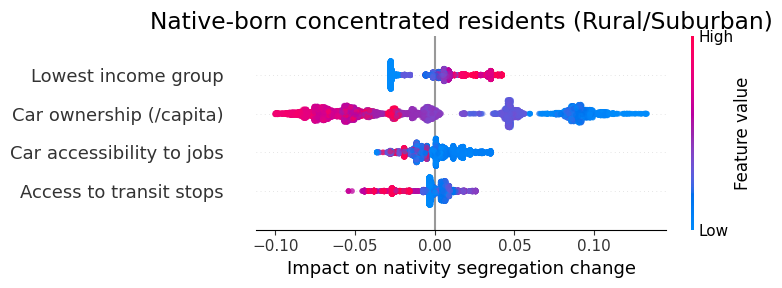

Exact explainer: 10001it [00:30, 211.70it/s]                          


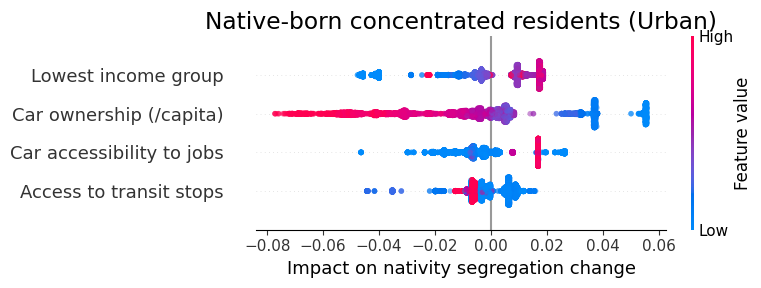

Exact explainer: 3927it [00:10, 19.52it/s]                           


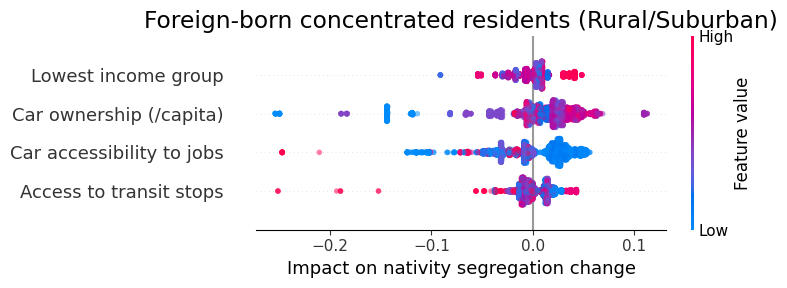

Exact explainer: 10001it [00:29, 213.79it/s]                          


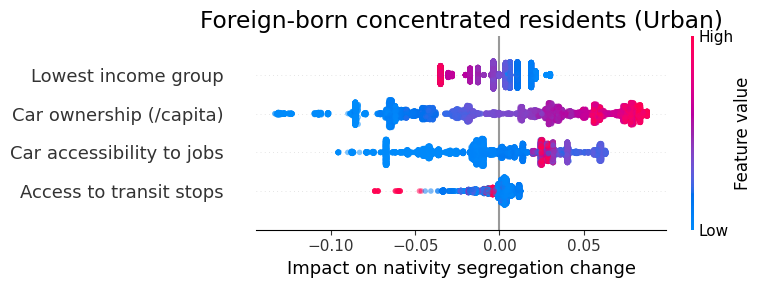

In [38]:
seg_dict = {'D': 'Native-born concentrated residents',
            'F': 'Foreign-born concentrated residents'}
for grp, df in df_exp.groupby(['seg_r', 'region_cat2']):
    title = seg_dict[grp[0]] + f' ({grp[1]})'
    ebm_group(df, title=title, weight_field='wt_p', shap_size=10000)